In [1]:
import torch
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
from manage_experiments import *

from utils_2 import generate_data_object_synthetic, generate_multidimensional_data_object_synthetic

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import json

In [2]:
# Import libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


def line_plot_with_std(list_scores, parameters, fname):

    # Convert the list of lists to a Pandas DataFrame
    df = pd.DataFrame(list_scores)

    # Calculate the mean and standard deviation of each row
    mean = df.mean(axis=1)
    std = df.std(axis=1)

    # Create a figure and an axis
    fig, ax = plt.subplots()

    # Plot the mean line
    ax.plot(mean, color='blue', label='Mean')

    # Plot the shaded region around the mean line
    ax.fill_between(df.index, mean-std, mean+std, color='lightblue', alpha=0.5, label='Standard deviation')

    # Add some labels and a legend
    ax.set_xlabel('Index')
    ax.set_ylabel('Value')
    # ax.legend()

    # change x-ticks to start from 
    n_tasks_per_student_list = list(range(
        parameters['min_n_tasks_per_student'],
        parameters['max_n_tasks_per_student'],
        parameters['step_n_tasks_per_student']))
    ax.set_xticks(range(len(n_tasks_per_student_list)), n_tasks_per_student_list, rotation=45)

    # Show and save the plot
    plt.grid()
    plt.xlabel('Number of tasks per student')
    plt.ylabel('Balanced Accuracy')
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)
    # plt.show()


In [3]:
def visualise_embeddings(json_content, fname):
    embeddings = json_content["embeddings"]
    embeddings_students = embeddings['student']
    embeddings_items = embeddings["item"]
    student_gaussians = json_content['student_gaussians']
    item_gaussians = json_content["item_gaussians"]
    item_difficulty = json_content["item_difficulty"]

    def plot_tsne(embeddings, targets, title, ax):
        # Perform t-SNE dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42, perplexity=20)
        embeddings_2d = tsne.fit_transform(np.array(embeddings))

        # Plotting the scatter plot
        ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=targets, cmap='viridis', alpha=0.5)
        ax.set_title(title)
        # ax.set_xlabel('t-SNE Dimension 1')
        # ax.set_ylabel('t-SNE Dimension 2')

    def plot_difficulty(embeddings, targets, title, ax):
        # Perform t-SNE dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42, perplexity=20)
        embeddings_2d = tsne.fit_transform(np.array(embeddings))

        # Plotting the scatter plot
        ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=targets, cmap='viridis', alpha=0.5)
        ax.set_title(title)

    # Creating subplots for t-SNE visualization
    fig, ax = plt.subplots(ncols=3,nrows=1, figsize=(12,6))

    plot_tsne(embeddings_items, item_gaussians, 'Items and Gaussians', ax[0])
    plot_tsne(embeddings_students, student_gaussians, 'Students and Gaussians', ax[1])
    plot_difficulty(embeddings_items, item_difficulty, 'Items and Difficulties', ax[2])

    plt.tight_layout()
    part1, part2 = fname.split('.')
    part1 = part1 + '_scatter'
    fname = '.'.join([part1, part2])
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)
    # plt.show()


In [4]:
def visualise_embeddings_concatenated(json_content, edge_label_index, y, fname, test_indices = None):

    def plot_tsne(embeddings, targets, title, ax):
        # Perform t-SNE dimensionality reduction
        tsne = TSNE(n_components=2, random_state=42)
        embeddings_2d = tsne.fit_transform(np.array(embeddings))

        # Plotting the scatter plot
        ax.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=targets, cmap='viridis', alpha=0.5)
        ax.set_title(title)
        # ax.set_xlabel('t-SNE Dimension 1')
        # ax.set_ylabel('t-SNE Dimension 2')

    embeddings = json_content["embeddings"]
    embeddings_students = torch.tensor(embeddings['student'])
    embeddings_items = torch.tensor(embeddings["item"])
    # student_ability = json_content['student_ability']
    # item_difficulty = json_content["item_difficulty"]

    edge_feat_student = embeddings_students[edge_label_index[0]]
    edge_feat_item = embeddings_items[edge_label_index[1]]

    concat_embeddings = torch.cat([edge_feat_student, edge_feat_item], dim=1)

    # Creating subplots for t-SNE visualization
    fig, ax = plt.subplots(ncols = 1, figsize=(8,6))

    if test_indices is None:
        plot_tsne(concat_embeddings, y, 'Edge Representations', ax)
    else:
        plot_tsne(concat_embeddings, [1 if i in test_indices else 0 for i in range(edge_label_index.shape[1])], 'Edge Representations', ax)

    plt.tight_layout()
    part1, part2 = fname.split('.')
    part1 = part1 + '_scatter_concatenated'
    fname = '.'.join([part1, part2])
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)
    # plt.show()


In [5]:
def visualise_confusion_matrix(json_content, fname):
    fig, ax = plt.subplots(ncols = 1, figsize=(8,6))
    
    plt.imshow(json_content["Confusion_2_test"], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.colorbar()

    classes = [0, 1]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    part1, part2 = fname.split('.')
    part1 = part1 + '_consfusion_matrix'
    fname = '.'.join([part1, part2])
    fnameplot = fname.replace('results', 'pdf')
    plt.savefig(fnameplot)

In [6]:
from IPython.utils import io
import matplotlib.pyplot as plt

import string
def create_filename_results(parameters,fold):
    file_name = ' '.join([f"{str(key)}-{str(value)}" for key, value in parameters.items() if key not in ['max_n_tasks_per_student','min_n_tasks_per_student']])
    file_name += ''.join(random.choice(string.ascii_letters + string.digits) for _ in range(4))
    file_name.replace(".","")
    file_name+=".results"
    return os.path.join(fold, file_name)


#n_students_per_task_list = [2**i for i in n_students_per_task_list]

import json
def synthetic_density_effect_runs(parameters,parameters_density, folder = 'synth_density_effect'):
    parameters = {**parameters, **parameters_density}
    n_tasks_per_student_list = list(range(
        parameters['min_n_tasks_per_student'],
        parameters['max_n_tasks_per_student'],
        parameters['step_n_tasks_per_student']))
    scores = []
    list_scores = []
    for n_task_per_student in tqdm(n_tasks_per_student_list):
        with io.capture_output() as captured:
            data = generate_multidimensional_data_object_synthetic(
                n_students = parameters['n_students'], # 72% of nodes were students
                n_tasks = parameters['n_tasks'],
                n_task_per_student = n_task_per_student,
                n_topics=parameters['n_topics'],
                dimension=parameters['dimension'],
                probabilistic = parameters['probabilistic'],
                number_of_tasks_per_students_is_max=parameters['number_of_tasks_per_students_is_max'])

            cv_out = perform_cross_validation(data, parameters, save_embeddings=True)
            embeddings = cv_out['embedding_2']
            if parameters['model_type'] == 'GNN':
                embeddings = {key:values.cpu().detach().numpy().tolist() for key, values in embeddings.items()}
            student_gaussians = data['student'].gaussians.cpu().detach().view(-1).numpy().tolist()
            item_gaussians = data['item'].gaussians.cpu().detach().view(-1).numpy().tolist()
            item_difficulty = data['item'].difficulty.cpu().detach().view(-1).numpy().tolist()
            score = 0
            inner_list_scores = []
            for fold_n in range(parameters["n_splits"]):
                score += cv_out[f"Balanced Accuracy_{fold_n}_test"]
                inner_list_scores.extend([cv_out[f"Balanced Accuracy_{fold_n}_test"]])
            
            score = score / parameters["n_splits"]
            scores.append(score)
            list_scores.append(inner_list_scores)

    res_dict = dict(zip(n_tasks_per_student_list,scores))
    output_dict = {
        **parameters,
        "embeddings":embeddings,
        'student_gaussians':student_gaussians,
        'item_gaussians':item_gaussians,
        'item_difficulty':item_difficulty,
        "res_dict":res_dict,
        "list_scores":dict(zip(n_tasks_per_student_list,list_scores))
    }
    fname = create_filename_results(parameters_density, folder)

    for key, value in cv_out["embedding_2"].items():
        cv_out["embedding_2"][key] = value.tolist()
        # print(key, type(value))
        
    with open(fname,'w') as f:
        json.dump(output_dict, f, skipkeys=True)
    
    # save results
    print(list_scores)
    line_plot_with_std(list_scores=list_scores, parameters= parameters, fname=fname)

    # save embeddings
    visualise_embeddings(output_dict, fname=fname)

    visualise_embeddings_concatenated(output_dict, data['student', 'responds', 'item'].edge_index, data['student', 'item'].y, fname = fname) # plot with indices of train-test split
    
    # plot with indices of train-test split
    


    visualise_confusion_matrix(cv_out, fname=fname)

In [7]:
parameters = {
    "hidden_dims": 3,
    'model_type': "IRT",
    "df_name": "synthetic.salamoia",
    "method": "EdgeClassifier",
    "epochs": 1000,
    "learning_rate": 0.05,
    "weight_decay": 0,
    "dropout": 0.0,
    "early_stopping": 250,
    "n_splits": 3,
    "device": "cuda",
    "done": False,
    "batch_size":128,
    "n_topics": 2,
    "dimension": 2,
    #
    }

parameters_density = {
    'n_students' :720, # 72% of nodes were students
    'n_tasks':280,
    'max_n_tasks_per_student':280, #280
    'min_n_tasks_per_student':261, #5
    'step_n_tasks_per_student':10, #10
    'probabilistic':None,
    'number_of_tasks_per_students_is_max':None
}


100%|██████████| 2/2 [03:15<00:00, 97.90s/it]


[[0.72765756302521, 0.72195779205365, 0.7132347567195082], [0.729569674657836, 0.7289839907670352, 0.7117851314841873]]


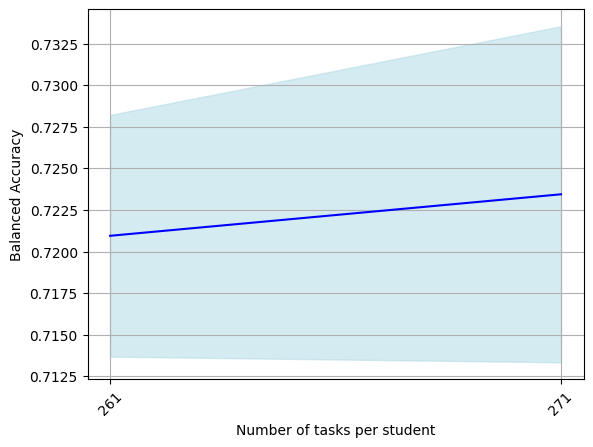

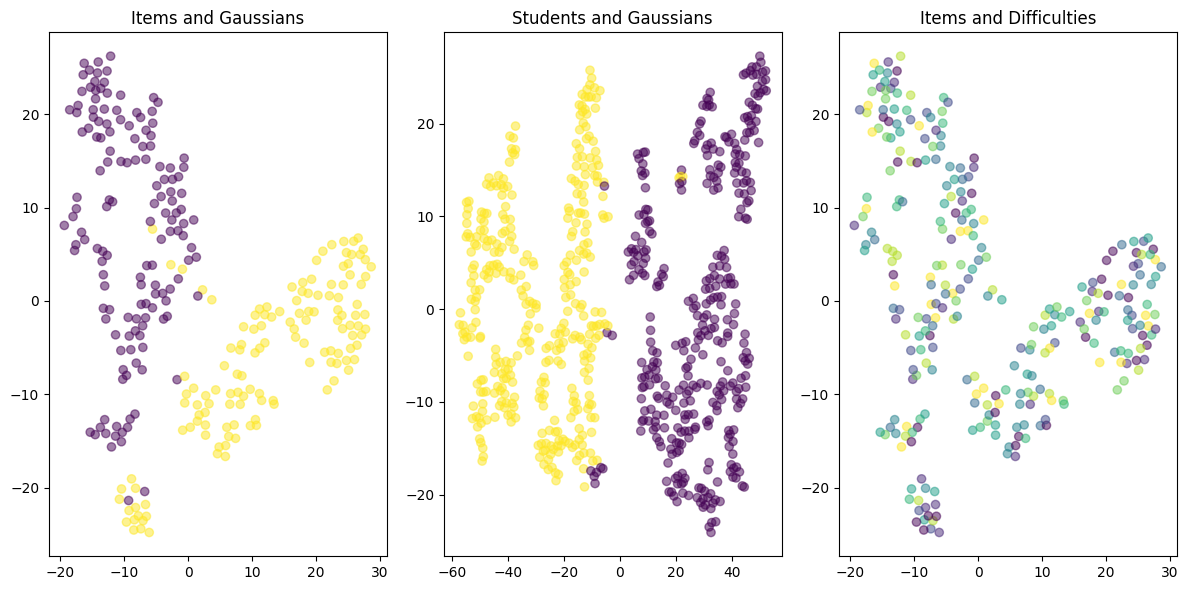

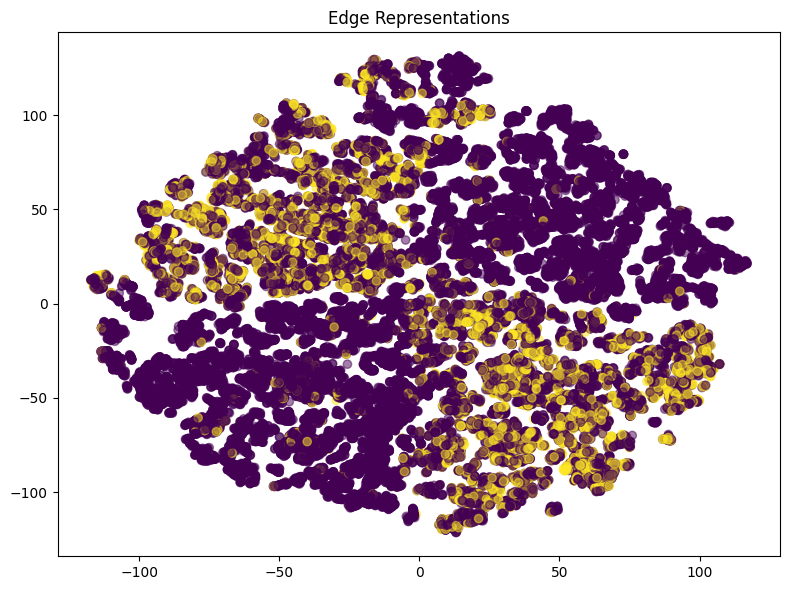

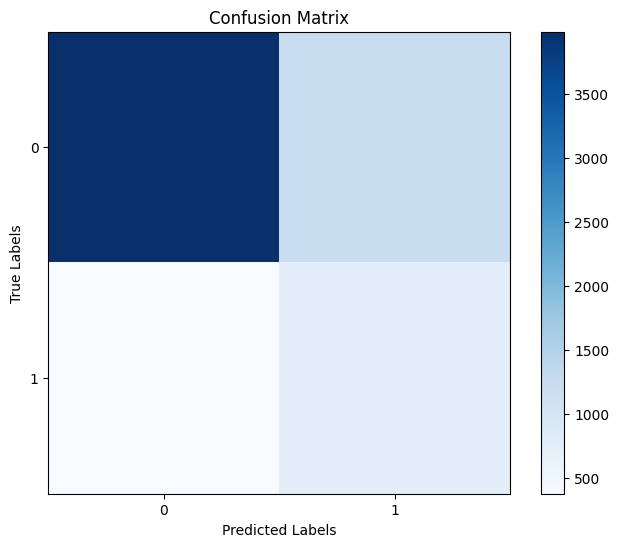

In [8]:
for probabilities in [1]:
    for number_of_tasks_per_students_is_max in [1]:
        parameters_density['probabilistic'] = probabilities
        parameters_density['number_of_tasks_per_students_is_max'] = 1#number_of_tasks_per_students_is_max
        synthetic_density_effect_runs(parameters=parameters,
                                    parameters_density=parameters_density,
                                    )

In [9]:
import numpy as np

In [10]:
def sigmoid(x, alpha):
    return 1/(1+np.exp(-x/alpha))

C:\Users\liq02qc\AppData\Local\Temp\ipykernel_18768\1727097957.py:2: RuntimeWarning: divide by zero encountered in scalar divide
  return 1/(1+np.exp(-x/alpha))
C:\Users\liq02qc\AppData\Local\Temp\ipykernel_18768\1727097957.py:2: RuntimeWarning: invalid value encountered in scalar divide
  return 1/(1+np.exp(-x/alpha))


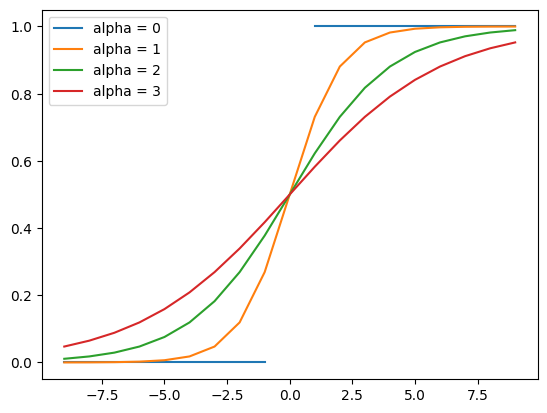

In [11]:
x = np.arange(-9,10)
plt.plot(x, [sigmoid(xi,0) for xi in x], label="alpha = 0")
plt.plot(x, [sigmoid(xi,1) for xi in x], label="alpha = 1")
plt.plot(x, [sigmoid(xi,2) for xi in x], label="alpha = 2")
plt.plot(x, [sigmoid(xi,3) for xi in x], label="alpha = 3")
plt.legend()